In [1]:
import os
import re
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
from tqdm import tqdm
import pickle
import seaborn as sb
import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt
import sys
from matplotlib.pyplot import rc_context
import scipy as sp
import scipy
from scipy import sparse
from matplotlib import rcParams
from concordex.concordex_stat import concordex_stat
import scrublet as scr
import scanorama

from PyQt5.QtCore import pyqtSlot, QSettings, QTimer, QUrl, QDir
from PyQt5.QtWidgets import QMainWindow, QFileDialog, QMessageBox, QApplication
matplotlib.use('Qt5Agg')

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.26.1 scipy==1.12.0 pandas==2.1.1 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.11


In [3]:
adata8monthorg = sc.read_h5ad('8monthorgsoupxcorrectformerge.h5ad')
adatapn100org = sc.read_h5ad('240229_pn100orgsoupxcorrectfiltformerge.h5ad')

In [4]:
adata8monthorg.var_names_make_unique() 
adatapn100org.var_names_make_unique() 

In [5]:
# add metadata to samples
adata8monthorg.obs['type']="Pig organoids"
adata8monthorg.obs['sample']="PN240 pig organoids"
adatapn100org.obs['type']="Pig organoids"
adatapn100org.obs['sample']="PN100 pig organoids"

In [6]:
#Concatanate
adata = adata8monthorg.concatenate(adatapn100org, batch_key='sample', join='inner', batch_categories=['PN240 pig organoids','PN100 pig organoids'])

/tmp/ipykernel_41482/2562199713.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata8monthorg.concatenate(adatapn100org, batch_key='sample', join='inner', batch_categories=['PN240 pig organoids','PN100 pig organoids'])


In [7]:
adata

AnnData object with n_obs × n_vars = 16761 × 25436
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'type', 'sample'
    var: 'mt', 'gene_ids-PN100 pig organoids', 'gene_ids_noext-PN100 pig organoids', 'gene_symbols_noext-PN100 pig organoids', 'n_cells-PN100 pig organoids', 'n_cells_by_counts-PN100 pig organoids', 'mean_counts-PN100 pig organoids', 'pct_dropout_by_counts-PN100 pig organoids', 'total_counts-PN100 pig organoids', 'gene_ids-PN240 pig organoids', 'gene_ids_noext-PN240 pig organoids', 'gene_symbols_noext-PN240 pig organoids', 'n_cells-PN240 pig organoids', 'n_cells_by_counts-PN240 pig organoids', 'mean_counts-PN240 pig organoids', 'pct_dropout_by_counts-PN240 pig organoids', 'total_counts-PN240 pig organoids'

In [8]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=True)
sc.pp.log1p(adata)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['GAPDH', 'KRTDAP', 'FABP5', 'S100A2', 'ENSSSCG00000006588', 'S100A8', 'ENSSSCG00000014540', 'ENSSSCG00000017445', 'ENSSSCG00000017448', 'ENSSSCG00000018063', 'SPRP', 'S100A12', 'ENSSSCG00000044834', 'ENSSSCG00000047299', 'ENSSSCG00000048856']
    finished (0:00:00)


In [9]:
#scanorama integration
adata.obs['sample'].value_counts()

sample
PN100 pig organoids    9252
PN240 pig organoids    7509
Name: count, dtype: int64

In [10]:
adatapp = adata.copy()
adatapp

AnnData object with n_obs × n_vars = 16761 × 25436
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'type', 'sample'
    var: 'mt', 'gene_ids-PN100 pig organoids', 'gene_ids_noext-PN100 pig organoids', 'gene_symbols_noext-PN100 pig organoids', 'n_cells-PN100 pig organoids', 'n_cells_by_counts-PN100 pig organoids', 'mean_counts-PN100 pig organoids', 'pct_dropout_by_counts-PN100 pig organoids', 'total_counts-PN100 pig organoids', 'gene_ids-PN240 pig organoids', 'gene_ids_noext-PN240 pig organoids', 'gene_symbols_noext-PN240 pig organoids', 'n_cells-PN240 pig organoids', 'n_cells_by_counts-PN240 pig organoids', 'mean_counts-PN240 pig organoids', 'pct_dropout_by_counts-PN240 pig organoids', 'total_counts-PN240 pig organoids'
    uns: 'log1p'
    layers: 'counts'

In [11]:
#Identify common variable genes between the two samples
sc.pp.highly_variable_genes(adatapp, flavor='cell_ranger', n_top_genes=2000, batch_key = 'sample')

print("Highly variable genes intersection: %d"%sum(adatapp.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adatapp.var.highly_variable_nbatches.value_counts())

var_genes_batch = adatapp.var.highly_variable_nbatches > 0

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 1254
Number of batches where gene is variable:
highly_variable_nbatches
0    22690
1     1492
2     1254
Name: count, dtype: int64


/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:489: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hvg = pd.concat([hvg, missing_hvg], ignore_index=True)
/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/preprocessing/_h

In [12]:
var_select = adatapp.var.highly_variable
var_genes = var_select.index[var_select]
len(var_genes)

2000

In [13]:
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs['sample'] == batch,]

alldata 

{'PN240 pig organoids': View of AnnData object with n_obs × n_vars = 7509 × 25436
     obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'type', 'sample'
     var: 'mt', 'gene_ids-PN100 pig organoids', 'gene_ids_noext-PN100 pig organoids', 'gene_symbols_noext-PN100 pig organoids', 'n_cells-PN100 pig organoids', 'n_cells_by_counts-PN100 pig organoids', 'mean_counts-PN100 pig organoids', 'pct_dropout_by_counts-PN100 pig organoids', 'total_counts-PN100 pig organoids', 'gene_ids-PN240 pig organoids', 'gene_ids_noext-PN240 pig organoids', 'gene_symbols_noext-PN240 pig organoids', 'n_cells-PN240 pig organoids', 'n_cells_by_counts-PN240 pig organoids', 'mean_counts-PN240 pig organoids', 'pct_dropout_by_counts-PN240 pig organoids', 'total_counts-PN240 pig organoids'
     uns: 'log1p'
     layers: 'counts',
 'PN100 pig organoids': View of AnnData object with n_obs × n_vars = 9252 × 25436
     obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_coun

In [14]:
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

PN240 pig organoids
PN100 pig organoids


In [15]:
adatas = list(alldata2.values())

In [16]:
scanorama.integrate_scanpy(adatas, dimred = 80)

Found 2000 genes among all datasets
[[0.         0.88214143]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanorama/scanorama.py:284: ImplicitModificationWarning: Setting element `.obsm['X_scanorama']` of view, initializing view as actual.
  adata.obsm['X_scanorama'] = X_dimred


In [17]:
adata_sc = adata.copy()

In [18]:
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

all_s = np.concatenate(scanorama_int)
print(all_s.shape)
adata_sc.obsm["Scanorama"] = all_s
adata_sc

(16761, 80)


AnnData object with n_obs × n_vars = 16761 × 25436
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'type', 'sample'
    var: 'mt', 'gene_ids-PN100 pig organoids', 'gene_ids_noext-PN100 pig organoids', 'gene_symbols_noext-PN100 pig organoids', 'n_cells-PN100 pig organoids', 'n_cells_by_counts-PN100 pig organoids', 'mean_counts-PN100 pig organoids', 'pct_dropout_by_counts-PN100 pig organoids', 'total_counts-PN100 pig organoids', 'gene_ids-PN240 pig organoids', 'gene_ids_noext-PN240 pig organoids', 'gene_symbols_noext-PN240 pig organoids', 'n_cells-PN240 pig organoids', 'n_cells_by_counts-PN240 pig organoids', 'mean_counts-PN240 pig organoids', 'pct_dropout_by_counts-PN240 pig organoids', 'total_counts-PN240 pig organoids'
    uns: 'log1p'
    obsm: 'Scanorama'
    layers: 'counts'

In [19]:
sc.pp.highly_variable_genes(adata_sc, flavor='cell_ranger', n_top_genes=2000, batch_key = 'sample')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:489: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hvg = pd.concat([hvg, missing_hvg], ignore_index=True)
/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/preprocessing/_h

In [20]:
sc.pp.neighbors(adata_sc,use_rep='Scanorama') 
sc.tl.umap(adata_sc)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [21]:
sc.tl.leiden(adata_sc, key_added='leiden_03', resolution=0.3)
sc.tl.rank_genes_groups(adata_sc, 'leiden_03',  method='wilcoxon')

running Leiden clustering
    finished: found 7 clusters and added
    'leiden_03', the cluster labels (adata.obs, categorical) (0:00:09)
ranking genes


/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:39)


In [22]:
markergenescluster = pd.DataFrame(adata_sc.uns['rank_genes_groups']['names']).head(20)
markergenescluster.to_csv("250414_markergeneclusters_piorgint_03leiden_scanorama.csv")

In [23]:
new_cluster_names = ["Basal_epithelial_cells", "Glycolysis_enriched_cells", "WNT_signaling_enriched_cells",
                     "Pancreatic_ductal_cells_1", "Proliferating_cells", "Pancreatic_ductal_cells_2","Pancreatic_ductal_cells_3"
]

adata_sc.rename_categories("leiden_03", new_cluster_names)

In [24]:
old_to_new = dict( Basal_epithelial_cells='Basal epithelial cells',
    Glycolysis_enriched_cells='Glycolysis enriched cells',
    WNT_signaling_enriched_cells='WNT signaling enriched cells',
    Proliferating_cells='Proliferating cells',
    Pancreatic_ductal_cells_1='Pancreatic ductal cells 1',
    Pancreatic_ductal_cells_3='Pancreatic ductal cells 1',
    Pancreatic_ductal_cells_2='Pancreatic ductal cells 2',
    )

In [25]:
adata_sc.obs['final_annotation'] = (
    adata_sc.obs['leiden_03']
    .map(old_to_new)
    .astype('category')
)

/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No

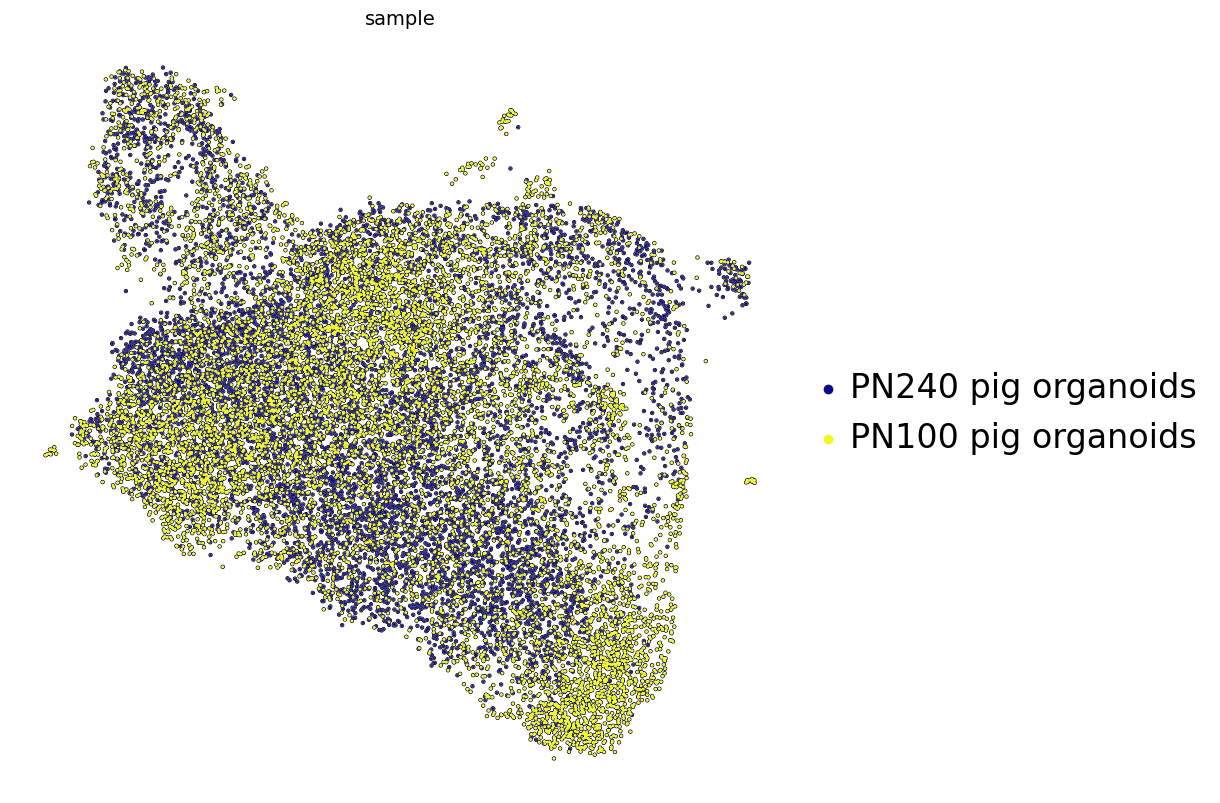

In [27]:
%matplotlib inline
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata_sc, color=['sample'], wspace=1, size=15,legend_fontsize=24, frameon= False, add_outline=True, alpha=0.9, outline_width=(0.3, 0.0),palette="plasma",   show=False)
    plt.savefig("250814_pigorg_int_anno_sample_rev1.eps", bbox_inches='tight')

In [30]:
sc.tl.rank_genes_groups(adata_sc, 'final_annotation',  method='wilcoxon')

top_genes = {}
for cluster in adata_sc.obs['final_annotation'].cat.categories:
    top_genes[cluster] = adata_sc.uns['rank_genes_groups']['names'][cluster][:5]

print(top_genes)

ranking genes


/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:37)
{'Basal epithelial cells': array(['MMP3', 'GPRL15', 'FGFBP1', 'S100A2', 'SERPINB2'], dtype=object), 'Glycolysis enriched cells': array(['GAPDH', 'ENO1', 'BNIP3', 'ADM', 'NDRG1'], dtype=object), 'Pancreatic ductal cells 1': array(['S100A12', 'CRABP2', 'KRTDAP', 'TMEM154', 'KRT23'], dtype=object), 'Pancreatic ductal cells 2': array(['KRT7', 'TCN1', 'KRT18', 'SORBS2', 'KRT8'], dtype=object), 'Proliferating cells': array(['HMGB2', 'SMC4', 'SMC2', 'H2AFZ', 'PCLAF'], dtype=object), 'WNT signaling enriched cells': array(['SOX6', 'ENSSSCG00000010893', 'LGR6', 'FGFR2', 'CACHD1'],
      dtype=object)}


/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/christos/anaconda3/envs/scanpyR_scanorama/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

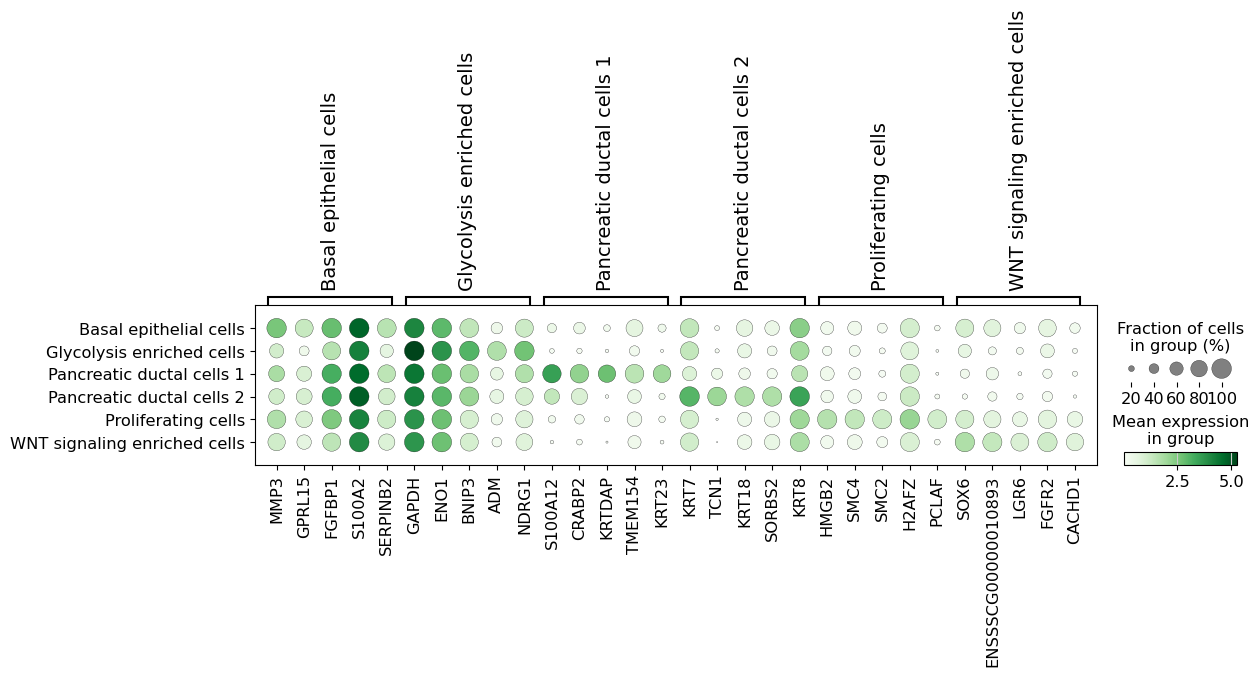

In [31]:
%matplotlib inline
sc.pl.dotplot(adata_sc, top_genes, groupby='final_annotation',cmap='Greens', show=False)
plt.savefig("240514_dotplot_scanint_top5markers.eps", bbox_inches='tight')